In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
 
from core.pretrained import ASTROMER_v1


%load_ext autoreload
%autoreload 2

### Loading data 

In [17]:
lcs_dir = './data/raw_data/css/LCs/'
metadata_file = './data/raw_data/css/CSS_dataset.dat'

In [18]:
metadata_df = pd.read_csv(metadata_file)

In [19]:
metadata_df['Class'].value_counts()

EW                49396
RRc                9185
EA                 9167
RRab               6745
Transient          3687
Rotational Var     3636
LPV                1798
RS_CVn             1514
RRd                1002
Misc                298
beta_Lyrae          279
CEPII               277
Blazkho             243
HADS                242
ACEP                215
EA_UP               153
DSC                 147
ELL                 142
PCEB                 85
Hump                 25
CEPI                 10
LADS                  7
Name: Class, dtype: int64

In [20]:
# ds_sample = pd.concat([group.sample(n=200) for lab, group in metadata_df.groupby('Class')])

In [23]:
times      = []
magnitudes = []
labels = []
for index, row in metadata_df.iterrows():
    lc = pd.read_csv(lcs_dir+'{}'.format(row['Path'].split('/')[-1]))
    lc = lc.iloc[:, :3]
    lc.columns = ['mjd','mag','magerr']
    lc = lc.sort_values('mjd')
    times.append(lc['mjd'].values)
    magnitudes.append(lc['mag'].values)
    labels.append(row['Class'])

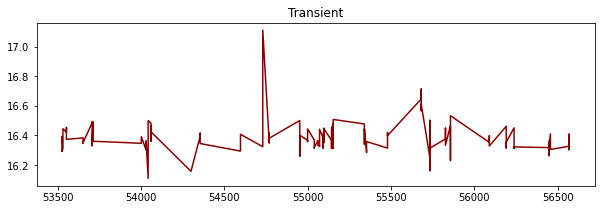

In [24]:
plt.figure(figsize=(10,3))
plt.plot(times[0], magnitudes[0], color='darkred')
plt.title('{}'.format(labels[0]))
plt.show()

# Finetuning

### Getting attention vectors from numpy lightcurves

In [5]:
astromer = ASTROMER_v1()

In [13]:
%%time
embs = astromer.encode(times=times, magnitudes=magnitudes, batch_size=2000)

CPU times: user 2min 54s, sys: 1min 36s, total: 4min 31s
Wall time: 58.5 s


### Getting attention vector from tf.record

In [32]:
from core.data import clf_records

subset = 'val'
dataset = clf_records('./data/records/alcock/{}'.format(subset), max_obs=200, batch_size=2000, take=-1)

[INFO] No shuffle No Oversampling


In [33]:
%%time
embs = astromer.encode(dataset)

CPU times: user 1min 14s, sys: 43.5 s, total: 1min 58s
Wall time: 24.3 s


In [34]:
times = []
magnitudes = []
uncert = []
labels = []
lengths = []
for batch in dataset:
    times.append(batch['times'])
    magnitudes.append(batch['input'])
    uncert.append(batch['obserr'])
    labels.append(batch['label'])
    lengths.append(batch['length'])

In [35]:
import tensorflow as tf 
times = tf.concat(times, 0 )
magnitudes = tf.concat(magnitudes, 0 )
uncert = tf.concat(uncert, 0 )
labels = tf.concat(labels, 0 )
lengths = tf.concat(lengths, 0 )

In [36]:
import h5py
hf = h5py.File('data/embeddings/alcock/{}.h5'.format(subset), 'w')
hf.create_dataset('times', data=times)
hf.create_dataset('magns', data=magnitudes)
hf.create_dataset('uncs', data=uncert)
hf.create_dataset('labels', data=labels)
hf.create_dataset('lens', data=lengths)
hf.create_dataset('att', data=embs)

<HDF5 dataset "att": shape (5116, 200, 256), type "<f4">

In [38]:
hf = h5py.File('data/embeddings/alcock/{}.h5'.format(subset), 'r')
hf['att']

<HDF5 dataset "att": shape (5116, 200, 256), type "<f4">

### Saving embeddings as tf.records

In [14]:
classes = list(metadata_df['Class'].unique())
labels_code = [classes.index(y) for y in labels]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(embs, labels_code, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

In [16]:
%%time
astromer.to_record(X_train, y_train, dest='./data/records/embeddings/train/css.record')
astromer.to_record(X_val, y_val, dest='./data/records/embeddings/val/css.record')
astromer.to_record(X_test, y_test, dest='./data/records/embeddings/test/css.record')

CPU times: user 1min 46s, sys: 1.19 s, total: 1min 48s
Wall time: 1min 48s


### Loading embedding datasets

In [22]:
import tensorflow as tf
import os

In [26]:
root = './embeddings/ogle_20/train/'
for index, x in enumerate(os.listdir(root)):
    if index == 0:
        dataset = tf.data.experimental.load(root+x)
    else:
        ds = tf.data.experimental.load(root+x)
        dataset.concatenate(ds)

In [29]:
for x in dataset:    
    print(x[0])


tf.Tensor(b'OGLE-BLG-LPV-043427', shape=(), dtype=string)
tf.Tensor(b'OGLE-BLG-RRLYR-02478', shape=(), dtype=string)
tf.Tensor(b'smc_sc2_i_43336', shape=(), dtype=string)
tf.Tensor(b'OGLE-LMC-RRLYR-00049', shape=(), dtype=string)
tf.Tensor(b'smc_sc4_i_120828', shape=(), dtype=string)
tf.Tensor(b'OGLE-BLG-LPV-051932', shape=(), dtype=string)
tf.Tensor(b'OGLE-GD-ECL-04098', shape=(), dtype=string)
tf.Tensor(b'OGLE-LMC-LPV-77961', shape=(), dtype=string)
tf.Tensor(b'OGLE-LMC-ECL-22071', shape=(), dtype=string)
tf.Tensor(b'OGLE-LMC-RRLYR-00129', shape=(), dtype=string)
